# Food-101 Vision Full model

## Table of Contents

1. **Data Handling:** Utilize TensorFlow Datasets to download and explore the complete Food101 dataset.
2. **Data Preprocessing:** Building a preprocessing function to prepare the data for model training.
3. **Dataset Preparation:** Batching and optimizing datasets for efficient model training, ensuring blazing-fast performance.
4. **Model Training:** We will set up essential callbacks for model training and dive into mixed precision training for enhanced speed and efficiency.
5. **Feature Extraction Model:** Creating a feature extraction model.
6. **Fine-Tuning:** Fine-tuning the feature extraction model to optimize its performance.
7. **Monitoring Progress:** Viewing training results for in-depth insights.

## Resources Check & Imports

In [1]:

import sys
sys.path.append('../')

# remove system logs
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # or any {"0", "1", "2"}

In [3]:
!nvidia-smi -L

/bin/bash: /root/miniconda3/envs/tf2/lib/libtinfo.so.6: no version information available (required by /bin/bash)
GPU 0: NVIDIA GeForce RTX 3070 (UUID: GPU-17663cf8-e59a-a0ea-7337-d7a8097f2cae)


In [12]:
from scripts.helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir
import tensorflow as tf
import tensorflow_datasets as tfds

print(f"TensorFlow version: {tf.__version__}")

# Get all available datasets in TFDS
datasets_list = tfds.list_builders()

# Set our target dataset and see if it exists
target_dataset = "food101"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

TensorFlow version: 2.13.0
'food101' in TensorFlow Datasets: True


## Data Download

In [5]:
data_dir = "../data/"

(train_data, test_data), ds_info = tfds.load(
    name="food101",
    split=["train", "validation"],
    shuffle_files=False,             # shuffle files on download?
    as_supervised=True,             # download data in tuple format (sample, label), e.g. (image, label)
    with_info=True,                  # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info))
    download=False,
    data_dir=data_dir)

In [6]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path='../data/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=75750,

## Preprocess Data

In [7]:
def preprocess_img(image, label, img_shape=(224, 224)):
  """
  1. Converts image Type from 'uint8' -> 'float32'
  2. Reshapes image to [img_shape, img_shape, color_channels]
  """
  img = tf.cast(image, tf.float32)
  img = tf.image.resize(img, img_shape)
  return img, label

In [8]:
# Map preprocessing function to training data (and paralellize)
train_data_prep = train_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data_prep = train_data_prep.shuffle(buffer_size=2000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data_prep = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data_prep = test_data_prep.batch(32).prefetch(tf.data.AUTOTUNE)

In [11]:
tf.keras.mixed_precision.set_global_policy(policy="mixed_float16")
tf.keras.mixed_precision.global_policy()

<Policy "mixed_float16">

## Data Augmentation Layer

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
  tf.keras.layers.RandomContrast(0.05),
  tf.keras.layers.RandomBrightness(0.05),
  # tf.keras.layers.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
], name ="data_augmentation")

## Base MODEL

In [14]:
# Create base model
input_shape = (224, 224, 3)
class_names = ds_info.features["label"].names

base_model = tf.keras.applications.EfficientNetV2B3(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="GlobalAveragePooling2D")(x)
x = tf.keras.layers.Dense(len(class_names))(x)
# Separate activation of output layer so we can output float32 activations
outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 GlobalAveragePooling2D (Gl  (None, 1536)              0         
 obalAveragePooling2D)                                           
                                                                 
 dense (Dense)               (None, 101)               155237    
                                                             

In [16]:
# Compile
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.legacy.Adam(),
              metrics=["accuracy"])

## Model 1 Callbacks 

In [17]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "../model_checkpoints/feature_extraction/cp.ckpt"                 # saving weights requires ".ckpt" extension

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor="val_accuracy",    # save the model weights with best validation accuracy
                                                         save_best_only=True,       # only save the best weights
                                                         save_weights_only=True,    # only save model weights (not whole model)
                                                         verbose=1)                 # don't print out whether or not model is being saved

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                           patience=3)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                          factor=0.5, 
                                                          patience=2,
                                                          min_lr=0.00025,
                                                          verbose=1)

## MODEL 1: Base model (Feature Extraction) 

In [18]:
history_feature_extraction = model.fit(train_data_prep,
                                       epochs=50,
                                       steps_per_epoch=len(train_data_prep),
                                       validation_data=test_data_prep,
                                       validation_steps=int(0.3 * len(test_data_prep)),
                                       callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback])

Epoch 1/50
2368/2368 [==============================] - ETA: 0s - loss: 2.1910 - accuracy: 0.4675
Epoch 1: val_accuracy improved from -inf to 0.63608, saving model to ../model_checkpoints/feature_extraction/cp.ckpt
2368/2368 [==============================] - 663s 275ms/step - loss: 2.1910 - accuracy: 0.4675 - val_loss: 1.3353 - val_accuracy: 0.6361 - lr: 0.0010
Epoch 2/50
2368/2368 [==============================] - ETA: 0s - loss: 1.7304 - accuracy: 0.5607
Epoch 2: val_accuracy improved from 0.63608 to 0.66073, saving model to ../model_checkpoints/feature_extraction/cp.ckpt
2368/2368 [==============================] - 363s 153ms/step - loss: 1.7304 - accuracy: 0.5607 - val_loss: 1.2379 - val_accuracy: 0.6607 - lr: 0.0010
Epoch 3/50
2368/2368 [==============================] - ETA: 0s - loss: 1.6126 - accuracy: 0.5870
Epoch 3: val_accuracy improved from 0.66073 to 0.67207, saving model to ../model_checkpoints/feature_extraction/cp.ckpt
2368/2368 [==============================] - 294s

In [22]:
# Save model locally
model.save("../saved_models/model_1/")
model.save_weights("../saved_weights/model_1/")

INFO:tensorflow:Assets written to: ../saved_models/model_1/assets


INFO:tensorflow:Assets written to: ../saved_models/model_1/assets


## Model Evaluation

In [23]:
evaluation_feature_extraction = model.evaluate(test_data_prep, return_dict=True)

790/790 [==============================] - 47s 59ms/step - loss: 1.0826 - accuracy: 0.7056


In [26]:
import pandas as pd
pd.DataFrame([evaluation_feature_extraction])


,loss,accuracy
0,1.082601,0.705584


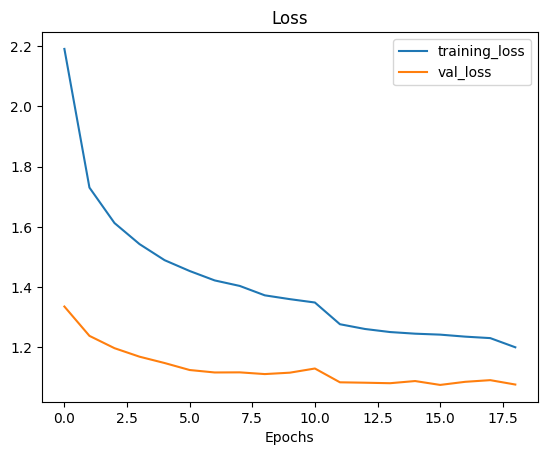

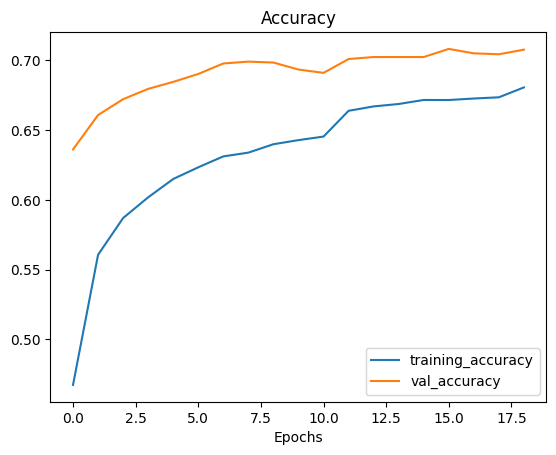

In [27]:
plot_loss_curves(history_feature_extraction)

# Fine tuning

In [28]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-150]:
  layer.trainable = False

# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv False
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv False
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block3a_expand_conv False
34 block3a_expand_bn False
35 block3a_expand_activation False
36 block3a_project_conv False
37 bl

In [29]:
# Create ModelCheckpoint callback to save model's progress
fine_tuning_checkpoint_path = "../model_checkpoints/fine_tuning/cp.ckpt"               # saving weights requires ".ckpt" extension

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(fine_tuning_checkpoint_path,
                                                         monitor="val_accuracy",    # save the model weights with best validation accuracy
                                                         save_best_only=True,       # only save the best weights
                                                         save_weights_only=True,    # only save model weights (not whole model)
                                                         verbose=1)                 # don't print out whether or not model is being saved

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                          factor=0.5, 
                                                          patience=2,
                                                          min_lr=0.000025,
                                                          verbose=1)

In [30]:
# Compile the model ready for fine-tuning
# Use the Adam optimizer with a 10x lower than default learning rate
model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 GlobalAveragePooling2D (Gl  (None, 1536)              0         
 obalAveragePooling2D)                                           
                                                                 
 dense (Dense)               (None, 101)               155237    
                                                             

In [32]:
history_feature_extraction.epoch[-1]

18

In [33]:
history_model_fine_tune_1= model.fit(train_data_prep,
                                       epochs=100,
                                       steps_per_epoch=len(train_data_prep),
                                       validation_data=test_data_prep,
                                       validation_steps=int(0.15 * len(test_data_prep)),
                                       initial_epoch=history_feature_extraction.epoch[-1],
                                       callbacks=[checkpoint_callback, reduce_lr_callback, early_stopping_callback])

Epoch 19/100


2368/2368 [==============================] - ETA: 0s - loss: 1.0827 - accuracy: 0.7095
Epoch 19: val_accuracy improved from -inf to 0.76615, saving model to model_checkpoints/fine_tuning/cp.ckpt
2368/2368 [==============================] - 335s 134ms/step - loss: 1.0827 - accuracy: 0.7095 - val_loss: 0.8303 - val_accuracy: 0.7662 - lr: 1.0000e-04
Epoch 20/100
2368/2368 [==============================] - ETA: 0s - loss: 0.8401 - accuracy: 0.7676
Epoch 20: val_accuracy improved from 0.76615 to 0.78125, saving model to model_checkpoints/fine_tuning/cp.ckpt
2368/2368 [==============================] - 326s 137ms/step - loss: 0.8401 - accuracy: 0.7676 - val_loss: 0.7717 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 21/100
2368/2368 [==============================] - ETA: 0s - loss: 0.6525 - accuracy: 0.8146
Epoch 21: val_accuracy improved from 0.78125 to 0.78178, saving model to model_checkpoints/fine_tuning/cp.ckpt
2368/2368 [==============================] - 320s 134ms/step - loss: 0.6525

In [34]:
evaluation_fine_tuning_1 = model.evaluate(test_data_prep, return_dict=True)

790/790 [==============================] - 49s 61ms/step - loss: 0.9469 - accuracy: 0.7810


In [35]:
pd.DataFrame([evaluation_fine_tuning_1])

,loss,accuracy
0,0.9469,0.78095


In [36]:
# Save model locally
model.save("../saved_models/model_2/")
model.save_weights("../saved_weights/model_2/")

INFO:tensorflow:Assets written to: ../saved_models/model_2/assets


INFO:tensorflow:Assets written to: ../saved_models/model_2/assets


## MODEL EVALUATION

|Model              | Loss  | Accuracy  |
|-------------------|:-----:|:---------:|
|Feature Extration  | 1.082 | 70.55%    |
|Fine Tuning        | 0.946 | 78.09%    |


In [38]:
pred_probs = model.predict(test_data_prep, verbose=1)
# How many predictions are there?
print(f"{len(pred_probs)=}\n{pred_probs.shape=}")
preds_classes = pred_probs.argmax(axis=1)
preds_classes


790/790 [==============================] - 49s 58ms/step
len(pred_probs)=25250
pred_probs.shape=(25250, 101)


array([29, 81, 62, ..., 46, 31, 21])

In [39]:
y_labels = []
for images, labels in test_data_prep.unbatch():
  y_labels.append(labels.numpy())

In [40]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, preds_classes)
print(f"accuracy = {sklearn_accuracy*100:.2f} %")

accuracy = 78.10 %


In [42]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
from scripts.helper_functions import make_confusion_matrix

make_confusion_matrix(y_true=y_labels,
                      y_pred=preds_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [43]:
from sklearn.metrics import classification_report

# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, preds_classes, output_dict=True)

# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

In [45]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

,class_name,f1-score
33,edamame,0.983936
63,macarons,0.956879
64,miso_soup,0.921488
76,pizza,0.919255
54,hot_and_sour_soup,0.914513


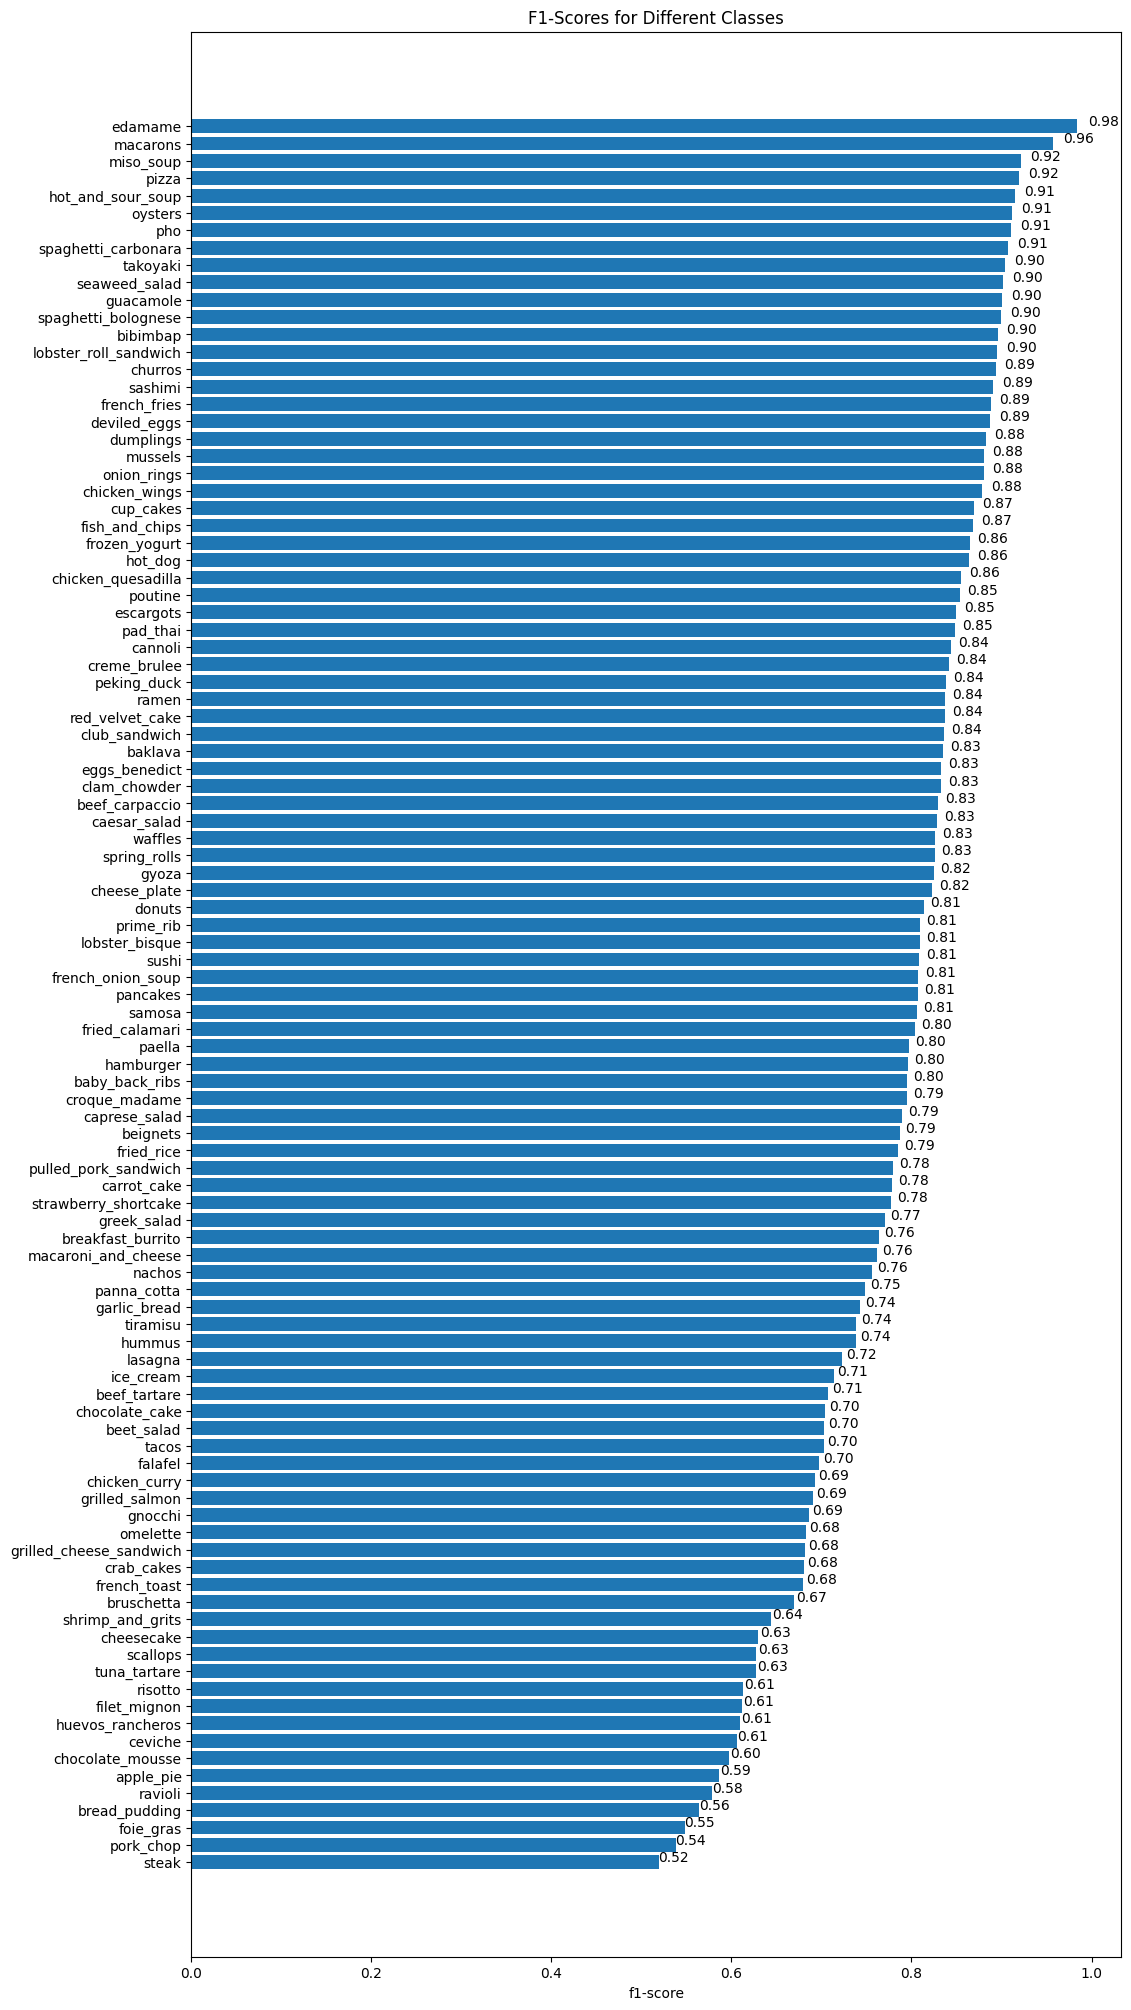

In [47]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)